# Building an ML pipeline from scratch

This notebook contains code for building modular machine learning pipeline that can be used to carry out regression and binary classification on datasets.

### A simple pipeline:

The ML pipeline can be broken down into 5 main stages:

1. **Loading a dataset and visualising it**.
    * Understanding underlying correlation in features, analysing the distribution of class labels and features.
    * Done in [Meet 1](https://github.com/ssncodingclub/Machine-Learning/blob/master/Meet-1/BasicDataAnalysis.ipynb).
2. **Pre-processing data**: 
    * Cleaning data (filling missing values, removing useless columns etc.)
    * Engineering new features (based on domain knowledge)
3. **Splitting the dataset** into train, validation (and test) sets.
    * Normalising data - ensuring the ranges of values of all features are the same.
    * Encoding data - ensuring categorical data is made numerical.
4. **Training an ML model** with chosen hyperparameters.
5. **Analysing metrics** to improve performance by choosing better hyperparameters.

For synthetic data, step 2 is not applicable.


Steps 2, 4, 5 are often done in a loop on a trial and error basis.

# Imports:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (8, 6) # Set size of matplotlib plots

## Some basic background before we start:

* A dataset is (usually) a table consisting of:
    * m rows - Each row is called a training example / data point, referring to one recording of real-world data.
    * n input feature columns - Each column is called a feature / attribute, referring to some specific data collected for each training example. The data in these columns are fed into the model.
    * 1 target column - this feature acts as the target, i.e: what we want the ML model to predict. All the other columns are inputs to our ML model.

For example, this is a dataset of info about different houses:

In [ ]:
house_df = pd.DataFrame({'House ID': [12, 34, 23], 
                         'Size (in sq. feet)': [4560, 3422, 5490], 
                         'Number of bedrooms': [3, 3, 2], 
                         'City': ['Chennai', 'Mumbai', 'Bangalore'],
                         'Price': [3056900, 4234000, 3890300]})
house_df

,House ID,Size (in sq. feet),Number of bedrooms,City,Price
0,12,4560,3,Chennai,3056900
1,34,3422,3,Mumbai,4234000
2,23,5490,2,Bangalore,3890300


In this case, the target column is 'Price', so our goal is to predict the price of a house given the size, number of bedrooms and city.

This is **supervised** regression problem.

Another point to note in this sample is that the values present in the column **City** are not numerical. Strings are not a valid input to ML models since we deal with mathematical equations involving matrices and need to be encoded in a manner such that they are transformed into numerical values. One such encoding is obtained by using [label encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) of the scikit-learn library

### Using label encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
le.fit(house_df.City)

LabelEncoder()

In [ ]:
le.classes_

array(['Bangalore', 'Chennai', 'Mumbai'], dtype=object)

In [ ]:
house_df

,House ID,Size (in sq. feet),Number of bedrooms,City,Price
0,12,4560,3,Chennai,3056900
1,34,3422,3,Mumbai,4234000
2,23,5490,2,Bangalore,3890300


#### Applying the label encoder

In [ ]:
encoded_house_df = house_df.copy()
encoded_house_df['City'] = le.transform(encoded_house_df['City'])
encoded_house_df

,House ID,Size (in sq. feet),Number of bedrooms,City,Price
0,12,4560,3,1,3056900
1,34,3422,3,2,4234000
2,23,5490,2,0,3890300


#### Inverting (Decoding) the numerical Representations

In [ ]:
decoded_house_df = encoded_house_df.copy()
decoded_house_df['City'] = le.inverse_transform(decoded_house_df['City'])
decoded_house_df

,House ID,Size (in sq. feet),Number of bedrooms,City,Price
0,12,4560,3,Chennai,3056900
1,34,3422,3,Mumbai,4234000
2,23,5490,2,Bangalore,3890300


## Some helper functions:

In [ ]:
class LinearRegression(object):
    
    def __init__(self):
        """ theta        -- Parameters (initialised in fit method)
            train_losses -- list of losses, populated during training. 
            val_losses   -- list of validation losses, populated during training. 
        """
        self.theta = None
        self.train_losses = []
        self.val_losses = []

    def predict(self, X):
        """Return predictions based on current parameters."""
        return X.dot(self.theta)

    def loss(self, X, y):
        """Return MSE loss function value to optimise."""
        return (1/2) * ((self.predict(X) - y) ** 2).mean()

    def gradient(self, X, y):
        """Return the gradient of the loss function."""
        return (1/X.shape[0]) * X.T.dot(self.predict(X) - y)

    def fit(self, X_train, y_train, X_val, y_val, lr=0.001, epochs=5):
        """Fit a Linear Regression model on the given data.
           X_train  -- train data (m * n matrix)
           y_train  -- train targets (m-dimensional vector)
           X_val    -- validation data (m' * n matrix)
           y_val    -- validation targets (m'-dimensional vector)
           lr       -- learning rate (default 0.01)
           epochs   -- number of times to iterate over data (default 1)
        """
        self.theta = np.zeros(X_train.shape[1])
        for epoch in range(epochs):
            self.theta = self.theta - lr * self.gradient(X_train, y_train)
            self.train_losses.append(self.loss(X_train, y_train))
            self.val_losses.append(self.loss(X_val, y_val))

    def plot_losses(self):
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.title("Loss Curve", fontsize=18)
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Error", fontsize=14)
        plt.legend()
        plt.show()


def gen_linear_dataset(n, scale, std_dev, c):
    """
    Generates a synthetic linear regression dataset
    n       -- Number of data points (rows)
    scale   -- Scaling factor
    std_dev -- Standard deviation
    c       -- intercept
    """
    x = np.array([i for i in range(n)])
    e = np.random.randn(n) * std_dev        # Sample from normal distribution and multiply by std deviation
    y = x * scale + e + c
    return x.reshape(-1, 1), y

def augment_with_zeros(X):
    """
    Appends 1 to each of the data points for bias input
    X -- Dataset containing all the x
    """
    return np.c_[X, np.ones(X.shape[0])]    # np.c_ is used to stack the args along the columns

def mean_squared_error(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()


# An example: Simple 2D Regression 

Before we delve into a real-world example, let's create the pipeline for toy data, and then use the various modules we create for a real-world dataset (graduate admissions prediction).



# Loading data:

* We generate a set of points in a 2D plane that follow a general linear relationship between y (our target) and x (our input). Generally, the dimensions of input x (number of columns) can be anything, for easy visualisation and math, we chose the input to be 1-dimensional.

* **Linear regression** is a supervised regression algorithm that works when the relationship between our features and target are linear.

### What is a model?

* A model is simply a function that maps our input features to the target. 
* In the house dataset example, a model would take the size, number of bedrooms and city as input and output a number which is the predicted price of the house with those features.
* In our toy data case, a model would take in an x value as input and produce a y value, thus it forms a line on this graph.
* **So the goal is to fit a straight line to the points in the graph**

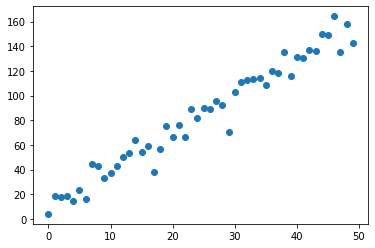

In [ ]:
X, y = gen_linear_dataset(50, 3, 8, 10)
plt.scatter(X[:, 0], y)
plt.show()

In [ ]:
pd.DataFrame({'Input': X[:, 0], 'Target': y}).head(10)

,Input,Target
0,0,4.032709
1,1,18.266477
2,2,17.533724
3,3,18.364406
4,4,14.535691
5,5,23.575227
6,6,15.982773
7,7,44.633466
8,8,42.841006
9,9,33.079981


## Some more background before we move on:

As outlined before, the goal is to fit a line to the set of points. <br/>
Let's define a simple straight line:

$$
\hat{y} = wx + b 
$$
So once an $w$ and $b$ have been chosen, for any $x$ the corresponding $\hat{y} $ can be calculated.
---
### What if we have more than one input (say $x_{1}$, $x_{2}$, $x_{3}$ etc.), let's make this more modular:

If each training example had say 3 features $x_{1}, x_{2}, x_{3}$, our model would be:
$$
\hat{y}  = w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3} + b
$$

In general,
$$
\hat{y} = w.x + b
$$
Where:
* $w$ (called as theta in the code) is a vector of weights/importances $[w_{1}, w_{2}, w_{3} \ldots w_{n}]$ <br />assigned to each input in a training example $x$ ($[x_{1}, x_{2}, x_{3} \ldots x_{n}]$) 
* $b$ is called a **bias**, which is independent of the input.
* In our house pricing example, n would be 3 as there are 3 input features and in our toy line dataset, n is 1.

### Let's make this even more simpler
The bias $b$ is basically multiplied by 1, so let's augment our input vector to have a 1 at the end to account for the bias, and lets append this bias as the last element of our weight vector $W$

$$
\hat{y} = w.x
$$

Where:
* $w$ is $[w_{1}, w_{2}, w_{3} \ldots w_{n},\: b]$
* $x$ is $[x_{1}, x_{2}, x_{3} \ldots x_{n},\: 1]$

### Still not simple enough...
Now, given a single training example (a row from our dataset), we can get the predicted output (a single number).

What if there is a way to evaluate the predictions of the whole dataset in one formula? That's where matrix operations comes in.

Assume our dataset has $m$ rows (training examples) and $n$ input features (excluding the target column). Now instead of feeding one row of this to the model, let's feed the entire dataset to the model. This dataset is a matrix of shape $m \times n$. 

Again, we have to augment this dataset to account for the bias $b$ in the $w$ vector. Unlike the previous case, instead of adding a 1 to the end of the $x$ vector, we add a **column** of ones to the end of the $X$ **matrix**.

After this, a simple matrix multiplication should do.

$$
\hat{Y} = X.w
$$

Where:

* $\hat{Y}$ is the m-dimensional vector of predictions (each entry corresponds to the prediction for each of the m training examples) Dimensions: $m \times 1$
* $w$ is $[w1, w2, w3..wn, b]$ - the same augmented weight vector (with the bias at the end), Dimensions: $(n+1) \times 1$
* $X$ is the dataset itself, consisting of m rows and (n+1) columns (the last column being just ones) Dimensions: $m \times (n+1)$
* Thus, $m \times (n+1)$ multiplied by $(n+1) \times 1$ gives $m \times 1$


### So we have a model, now what?

As you have seen, the model is characterised purely by it $w$ vector (the vector of all the weights assigned to each feature and the bias). The goal is to fit the line to the points, but what does **a good fit** even mean?

Each fit is essentially one configuration of the $w$ vector, there are infinitely many values this vector can take. How do we decide a fit is _good_?

Well, we have to mathematically define what **good** means:
How close are the predicted values $\hat{Y}$ to the actual values $Y$?

This functions is what we call a **Loss** function in ML and it takes many forms depending on the type of problem, a simple measure is the mean squared error between predicted and actual values:

$$
L(y, \hat{y}) = \frac{1}{2m}\sum_{i=1}^{m}(\hat{y} - y)^2
$$

### So lower the MSE, the better. Now we can easily evaluate how a model is doing. By model, again we mean some specific configuration of the $w$ vector. Thus, this loss is a function of the vector $w$ itself and our goal is now to tweak $w$ so as to minimise this loss value.



# Pre-processing the data:

Since this is a synthetic dataset, this step does **not** apply here.

# Splitting data:

* To validate how our model is doing, we use a separate validation dataset (pre-processed exactly like the training dataset).
* The validation data is not used for training, rather we just observe MSE loss on those data points to see how our model is doing. Using the training data for this purpose is misleading, as the model will obviously perform well on the training data, it is being trained on it after all.
* We usually split the entire dataset into train and validation as a 80-20 split. i.e: 80% of data is training data, remaining is for validation.


In [ ]:
# To add a column of ones in the dataset to account for bias
X = augment_with_zeros(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

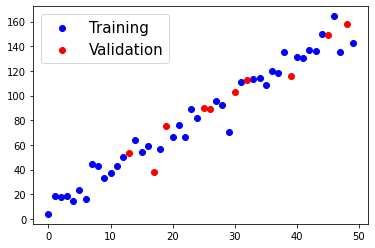

In [ ]:
plt.scatter(X_train[:, 0], y_train, c='b', label="Training")
plt.scatter(X_val[:, 0], y_val, c='r', label="Validation")
plt.legend(fontsize=15)
plt.show()

# Training the model:

## How do we minimise the loss?

This is where optimisation algorithms come in. Let's look at the simplest one, **Gradient Descent**

### Gradient Descent:

What is a gradient of a function? <br />
Consider a function that takes a n-dimensional vector as input.
Now, if we find the derivative of this function with respect to each component of this vector (i.e: each input), and make those values into a n-dimensional vector, that becomes the gradient.
Thus, a gradient is also a vector. More importantly, it specifies the direction in which the input must be changed to increase the value of the function the most. <br />

i.e: The gradient is the direction of **steepest ascent**.
Thus, moving the input $w$ by the gradient ($w$ + gradient) will increase the value of the function the most.

Now, we have a similar situation with a loss function that takes in an n-dimensional vector $w$ as input. But our goal is to **minimise** this loss function. Hence, we move in the direction of **negative of gradient**. Hence, the name: Gradient Descent. 

Gradient Descent update rule:

$$
w' = w - \eta * \nabla L(w)
$$

where $\eta$ is the learning rate. To start off, the weights can be randomly intialiased or can all be set to zero (what we do in the code).

This process is done iteratively, we calculate the gradient of the loss (over all training examples), adjust the weights, again the calculate the gradient, adjust weights and so on.

The number of times the model sees the whole training data is called number of **epochs**.
We scale the amount by which we move, this scaling factor applied to the gradient is called the **learning rate**, which has a major impact on how training proceeds.

These parameters are set by us and not learnt by the algorithm, hence they have a special name: **hyperparameters**


In [ ]:
model = LinearRegression()
model.fit(X_train, 
          y_train,
          X_val,
          y_val,
          lr=0.002,
          epochs=10)

print("Training Complete")
print(model.theta)

Training Complete
[3.27772359 0.15894438]


# Analysing performance:

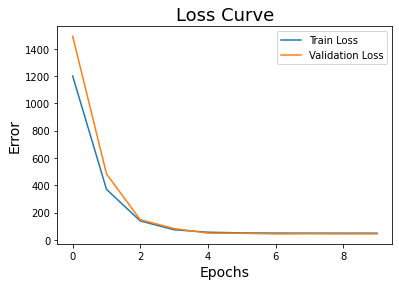


Validation set MSE: 89.59135569262625


In [ ]:
model.plot_losses()

print(f'\nValidation set MSE: {mean_squared_error(y_val, model.predict(X_val))}')

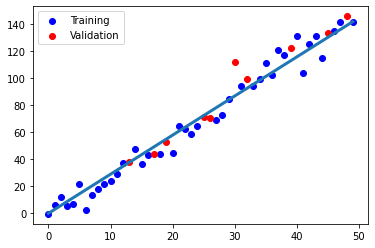

In [ ]:
plt.scatter(X_train[:, 0], y_train, c='b', label="Training")
plt.scatter(X_val[:, 0], y_val, c='r', label="Validation")
plt.plot(X[:, 0], model.predict(X), linewidth=3)
plt.legend()
plt.show()